In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

import numpy as np

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns

sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Download Data

## Mutual Information

In [6]:
from pysim.data.information.gaussian import generate_gaussian_mi_data
from pysim.data.information.studentt import generate_studentt_mi_data

In [26]:
n_samples = 50_000
n_features = 2
seed = 1
df = 5

# create seed (trial number)
res_dict = generate_studentt_mi_data(
    n_samples=n_samples, n_features=n_features, df=df, seed=seed,
)
res_dict = generate_gaussian_mi_data(
    n_samples=n_samples, n_features=n_features, seed=seed,
)

In [27]:
res_dict.MI

0.166460644947092

## Estimators

In [30]:
from pysim.information.gaussian import gauss_entropy_multi
from pysim.information.knn import knn_entropy, knn_entropy_npeet
from pysim.information.mutual import multivariate_mutual_information
import time


def get_mi_estimators(X, Y):

    t0 = time.time()
    res = multivariate_mutual_information(X=X.copy(), Y=Y.copy(), f=gauss_entropy_multi)
    print(f"Gaussian: {res['mi']:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    res = multivariate_mutual_information(
        X=X.copy(), Y=Y.copy(), f=knn_entropy, n_neighbors=10, n_jobs=-1
    )
    print(f"KNN (Neighbours):  {res['mi']:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    res = multivariate_mutual_information(
        X=X.copy(), Y=Y.copy(), f=knn_entropy_npeet, n_neighbors=10, n_jobs=-1
    )
    print(f"KNN (epsilon):  {res['mi']:.4f} | Time: {time.time()-t0:.4f} secs")

In [31]:
get_mi_estimators(res_dict.X, res_dict.Y)

Gaussian: 0.1715 | Time: 0.0144 secs
KNN (Neighbours):  0.1990 | Time: 1.2044 secs
KNN (epsilon):  -0.1929 | Time: 1.0245 secs


## Demo Experiment

In [32]:
n_samples = [500, 1_000, 5_000, 10_000]  # 10_000, 30_000, 50_000]
n_features = [10]  # [2, 3, 10, 50, 100]
n_trials = 10
df = 3

In [33]:
from tqdm.notebook import tqdm, trange
import pandas as pd
import itertools

iteration = itertools.count()


all_stats = pd.DataFrame()

pbar_features = tqdm(n_features, leave=True)

for i_features in pbar_features:

    pbar_features.set_description(f"Features: {i_features}")

    results = {}

    pbar_samples = tqdm(n_samples, leave=False)

    for i_samples in pbar_samples:

        pbar_samples.set_description(f"Samples: {i_samples}")

        pbar_trials = trange(n_trials, leave=False)

        for i_trial in pbar_trials:

            pbar_trials.set_description(f"Trials: {i_trial} | Method: GT")

            # generate data
            res_dict = generate_studentt_mi_data(
                n_samples=i_samples, n_features=i_features, df=df, seed=i_trial,
            )
            #             res_dict = generate_gaussian_mi_data(
            #                 n_samples=i_samples, n_features=i_features, seed=i_trial,
            #             )
            results = {
                "method": "truth",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "mi": res_dict.MI,
            }
            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )

            # ======================
            # Gaussian Estimation
            # ======================
            pbar_trials.set_description(f"Trials: {i_trial} | Method: Gaussian")
            output = multivariate_mutual_information(
                X=res_dict.X.copy(), Y=res_dict.Y.copy(), f=gauss_entropy_multi
            )
            results = {
                "method": "gaussian",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "mi": output["mi"],
            }

            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )
            # ==========================
            # KNN estimated (Neighbors)
            # ==========================

            pbar_trials.set_description(f"Trials: {i_trial} | Method: KNN (Neighbors)")

            output = multivariate_mutual_information(
                X=res_dict.X.copy(),
                Y=res_dict.Y.copy(),
                f=knn_entropy,
                n_neighbors=10,
                base=2,
            )
            results = {
                "method": "knn",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "mi": output["mi"],
            }

            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )

            # ==========================
            # KNN estimated (Epsilon)
            # ==========================
            pbar_trials.set_description(
                f"Trials: {i_trial} | Method: KNN (Epsilon-Ball)"
            )

            output = multivariate_mutual_information(
                X=res_dict.X.copy(),
                Y=res_dict.Y.copy(),
                f=knn_entropy_npeet,
                n_neighbors=10,
                base=2,
            )
            results = {
                "method": "knn_tree",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "mi": output["mi"],
            }

            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
all_stats.head()

,method,n_samples,n_features,trial,mi
0,truth,500,10,0,5.189690
1,gaussian,500,10,0,4.796933
2,knn,500,10,0,0.882974
3,knn_tree,500,10,0,-2.630373
4,truth,500,10,1,3.134896


In [35]:
all_stats_ = all_stats.copy()
all_stats_["algorithm"] = all_stats_["method"]
all_stats_ = all_stats_.drop(["method"], axis=1)

In [36]:
all_stats_ = all_stats_.set_index(["n_samples", "n_features", "trial", "algorithm"])

In [37]:
stats_ds = all_stats_.to_xarray()

In [38]:
stats_ds

<xarray.Dataset>
Dimensions:     (algorithm: 4, n_features: 1, n_samples: 4, trial: 10)
Coordinates:
  * n_samples   (n_samples) int64 500 1000 5000 10000
  * n_features  (n_features) int64 10
  * trial       (trial) int64 0 1 2 3 4 5 6 7 8 9
  * algorithm   (algorithm) object 'gaussian' 'knn' 'knn_tree' 'truth'
Data variables:
    mi          (n_samples, n_features, trial, algorithm) float64 4.797 ... 3...

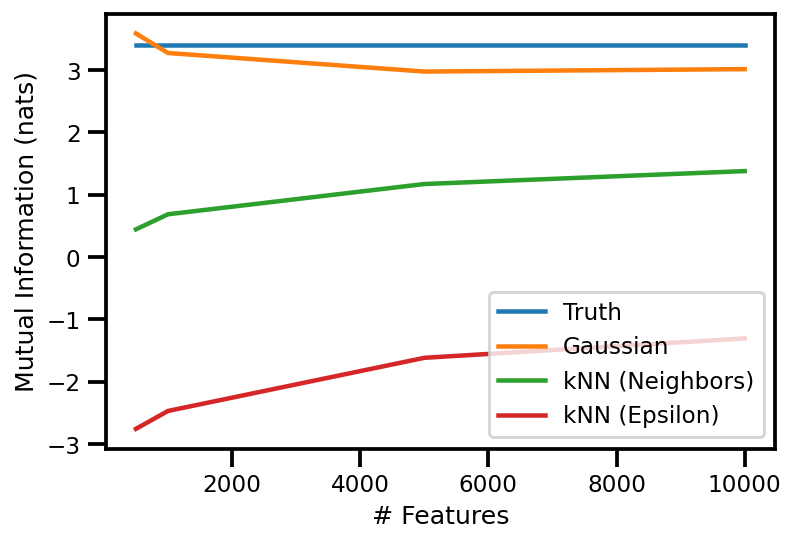

In [39]:
fig, ax = plt.subplots()


stats_ds.sel(n_features=n_features, algorithm="truth").mean(["trial"]).mi.plot(
    ax=ax, label="Truth"
)
stats_ds.sel(n_features=n_features, algorithm="gaussian").mean(["trial"]).mi.plot(
    ax=ax, label="Gaussian"
)
stats_ds.sel(n_features=n_features, algorithm="knn").mean(["trial"]).mi.plot(
    ax=ax, label="kNN (Neighbors)"
)
stats_ds.sel(n_features=n_features, algorithm="knn_tree").mean(["trial"]).mi.plot(
    ax=ax, label="kNN (Epsilon)"
)


ax.set(xlabel="# Features", ylabel="Mutual Information (nats)", title="")
ax.legend()
plt.show()

In [40]:
def percent_error(real, pred):
    pred = np.abs(np.abs(pred - real) / real)
    return pred

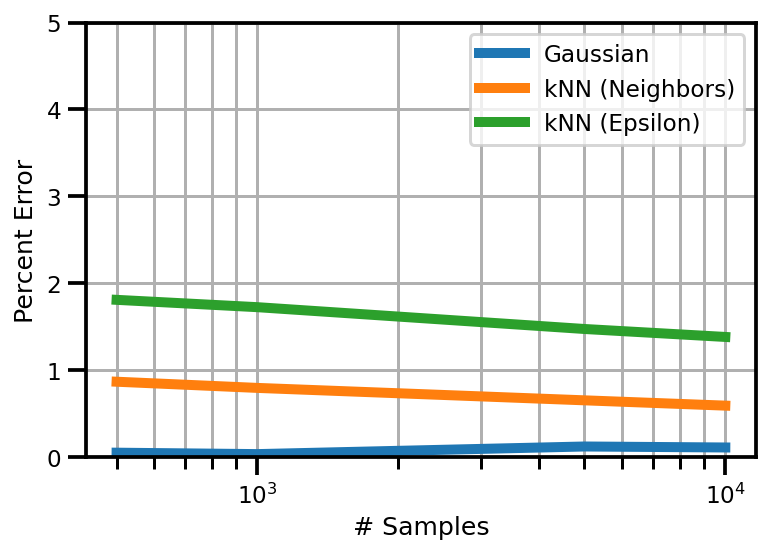

In [43]:
fig, ax = plt.subplots()

real = stats_ds.sel(n_features=10, algorithm="truth").mean(["trial"]).mi

# stats_ds.sel(n_features=10, algorithm="truth_nats").mean(["trial"]).H.plot(
#     ax=ax, label="Truth", linewidth=5, color="black"
# )

t = percent_error(
    real, stats_ds.sel(n_features=10, algorithm="gaussian").mean(["trial"]).mi
)
t.plot(ax=ax, label="Gaussian", linewidth=5, linestyle="-")


t = percent_error(real, stats_ds.sel(n_features=10, algorithm="knn").mean(["trial"]).mi)
t.plot(ax=ax, label="kNN (Neighbors)", linewidth=5, linestyle="-")

t = percent_error(
    real, stats_ds.sel(n_features=10, algorithm="knn_tree").mean(["trial"]).mi
)
t.plot(ax=ax, label="kNN (Epsilon)", linewidth=5, linestyle="-")


ax.set(
    xlabel="# Samples", ylabel="Percent Error", title="", xscale="log", ylim=[0.0, 5.0]
)
ax.grid(True, which="both")
ax.legend()
plt.show()

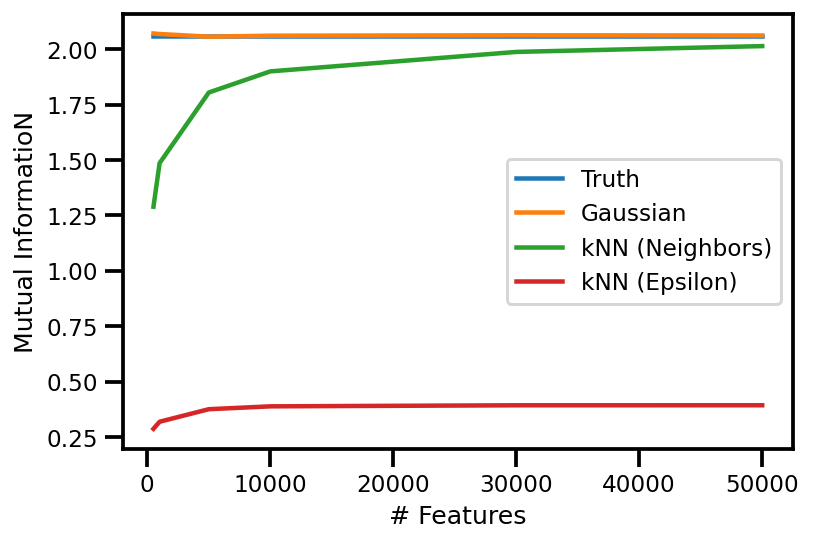

In [51]:
fig, ax = plt.subplots()
import numpy as np

stats_ds.sel(n_features=n_features, algorithm="truth").mean(["trial"]).mi.plot(
    ax=ax, label="Truth"
)
stats_ds.sel(n_features=n_features, algorithm="gaussian").mean(["trial"]).mi.plot(
    ax=ax, label="Gaussian"
)
stats_ds.sel(n_features=n_features, algorithm="knn").mean(["trial"]).mi.plot(
    ax=ax, label="kNN (Neighbors)"
)
t = stats_ds.sel(n_features=n_features, algorithm="knn_tree").mean(
    ["trial"]
).mi / np.log(10)
t.plot(ax=ax, label="kNN (Epsilon)")

ax.set(xlabel="# Features", ylabel="Mutual InformatioN", title="")
ax.legend()
plt.show()

In [76]:
stats_ds.sel(n_samples=10_000, algorithm="gaussian")

<xarray.Dataset>
Dimensions:     (n_features: 6, trial: 10)
Coordinates:
    n_samples   int64 10000
  * n_features  (n_features) int64 2 3 5 10 50 100
  * trial       (trial) int64 0 1 2 3 4 5 6 7 8 9
    algorithm   <U8 'gaussian'
Data variables:
    mi          (n_features, trial) float64 0.928 0.6887 1.187 ... -26.37 -26.15